<a href="https://colab.research.google.com/github/aditya5172/Bank-Loan-Prediction/blob/main/Loan_Predictor_better_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import joblib
import xgboost as xgb

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif,SelectKBest,chi2,f_classif
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

In [3]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [4]:
from sklearn.utils import resample
majority=train[(train['Loan_Status']=='Y')]
minority=train[(train['Loan_Status']=='N')]

y_minority_upsampled=resample(minority,
                               replace=True,
                               n_samples=len(majority),
                               random_state=42)

df_upsampled=pd.concat([y_minority_upsampled,majority])


In [5]:
X=df_upsampled.drop(['Loan_ID','Loan_Status'],axis=1)
y=df_upsampled['Loan_Status']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [7]:
trf1=ColumnTransformer(transformers=[
    ('b1',SimpleImputer(strategy='most_frequent'),[0,1,2,4,8,9]),
    ('g1',SimpleImputer(strategy='median'),[7])
    
],remainder='passthrough')

In [8]:
X_train=trf1.fit_transform(X_train)

In [10]:
trf2=ColumnTransformer(transformers=[
    ('a2',OneHotEncoder(sparse=False,handle_unknown='ignore'),[0,1,2,3,4,7,10]),
],remainder='passthrough')

In [11]:
X_train=trf2.fit_transform(X_train)

In [12]:
d={}
x=X_train.T
for i in range(0,len(trf2.get_feature_names())):
    d[trf2.get_feature_names()[i]]=x[i]
d=pd.DataFrame(d)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
X_test=trf1.transform(X_test)
X_test=trf2.transform(X_test)

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

def sk(ii):
  xy={}
  for i in range(len(X_train.T)):
      xy[str(i)] = X_train.T[i]
  xy=pd.DataFrame(xy)
  sel_col=SelectKBest(mutual_info_classif,k=ii)
  sel_col.fit(xy,y_train)
  feature_selected_columns=xy.columns[sel_col.get_support()]
  xyz={}
  for i in range(len(X_test.T)):
      xyz[str(i)] = X_test.T[i]
  xyz=pd.DataFrame(xyz)
  mutual_info = mutual_info_classif(xy,y_train)
  mutual_info = pd.Series(mutual_info)
  mutual_info.index=xy.columns
  xy=xy[feature_selected_columns]
  xyz=xyz[feature_selected_columns]
  
  return xy,xyz

In [34]:
xy,xyz=sk(10)

In [33]:
from sklearn.model_selection import KFold, cross_val_score
k_folds = KFold(n_splits = 5)

In [71]:
from sklearn.metrics import f1_score

In [150]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

y_train=label_encoder.fit_transform(y_train)
y_test=label_encoder.fit_transform(y_test)

# Full Tree

In [153]:
def tree(xy,xyz):
  full_tree=DecisionTreeClassifier(random_state=42)
  full_tree.fit(xy,y_train)
  return f1_score(y_test,full_tree.predict(xyz))
  

# Post Purning

In [154]:
def post_p(xy,xyz):
  full_tree=DecisionTreeClassifier(random_state=42)
  #full_tree.fit(xy,y_train)
  ccp_alpha=full_tree.cost_complexity_pruning_path(xy,y_train)["ccp_alphas"]
  ccp_alpha_grid_search=GridSearchCV(
      estimator=DecisionTreeClassifier(random_state=42),
      scoring=make_scorer(accuracy_score),
      param_grid=ParameterGrid({"ccp_alpha":[[alpha] for alpha in ccp_alpha]}),
  )
  ccp_alpha_grid_search.fit(xy,y_train)
  best_ccp=ccp_alpha_grid_search.best_estimator_
  return f1_score(y_test,best_ccp.predict(xyz)) #post purning
  

# Pre Purning Split

In [155]:
def pre_p_s(xy,xyz):
  mini_samples_split_grid_search=GridSearchCV(
                              estimator=DecisionTreeClassifier(random_state=42),
      scoring=make_scorer(accuracy_score),
      param_grid=ParameterGrid({
          "min_samples_split":[
              [m] for m in np.arange(0.0001,1,0.025)
          ]
      })
  )
  mini_samples_split_grid_search.fit(xy,y_train)
  best_pre=mini_samples_split_grid_search.best_estimator_
  return f1_score(y_test,best_pre.predict(xyz)) # pre purning split
  

# Pre purning leaf

In [156]:
def pre_p_l(xy,xyz):
  mini_samples_leaf_grid_search=GridSearchCV(
  estimator=DecisionTreeClassifier(random_state=42),
      scoring=make_scorer(accuracy_score),
      param_grid=ParameterGrid({
          "min_samples_leaf":[
              [m] for m in np.arange(0.0001,0.5,0.025)
          ]
      })
  )
  mini_samples_leaf_grid_search.fit(xy,y_train)
  best_pre_leaf=mini_samples_leaf_grid_search.best_estimator_
  return f1_score(y_test,best_pre_leaf.predict(xyz))  #pre purning leaf

# Ada Boost

In [157]:
 def ada(xy,xyz):
  abc=AdaBoostClassifier(n_estimators=50,learning_rate=0.25,random_state=0)
  abc.fit(xy,y_train)
  return f1_score(y_test,abc.predict(xyz))

# Gradient Boost

In [158]:
def grade(xy,xyz):
  gradient_booster = GradientBoostingClassifier(learning_rate=0.30)
  gradient_booster.fit(xy,y_train)
  return f1_score(y_test,gradient_booster.predict(xyz))

# XGBoost

In [159]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost 
def xgb(xy,xyz):
  classifier=xgboost.XGBClassifier()#tree_method="gpu_hist",enable_categorical=True)
  model = xgboost.XGBClassifier( tree_method="hist", enable_categorical=True)
  yy=pd.get_dummies(y_train)
  classifier.fit(xy.values,y_train)
  y_pred=classifier.predict(xyz.values)
  yy=pd.get_dummies(y_test)
  return f1_score(y_test,y_pred)

In [191]:
def all():
  xy,xyz=sk(5)
  res={'Tree':0,'Post puring':0,'Pre Puring Leaf':0,
       'Pre Puring Split':0,'Adaboost':0,
       'Gradient Decent':0,'XGB':0}
  res["Tree"]=round(tree(xy,xyz)*100,2)
  res["Post puring"]=round(post_p(xy,xyz)*100,2)
  res["Pre Puring Leaf"]=round(pre_p_l(xy,xyz)*100,2)
  res["Pre Puring Split"]=round(pre_p_s(xy,xyz)*100,2)
  res["Adaboost"]=round(ada(xy,xyz)*100,2)
  res["Gradient Decent"]=round(grade(xy,xyz)*100,2)
  res["XGB"]=round(xgb(xy,xyz)*100,2)
  return res

In [192]:
res=all()

{'Tree': 81.48,
 'Post puring': 81.48,
 'Pre Puring Leaf': 81.48,
 'Pre Puring Split': 81.48,
 'Adaboost': 77.03,
 'Gradient Decent': 90.6,
 'XGB': 81.48}

<BarContainer object of 7 artists>

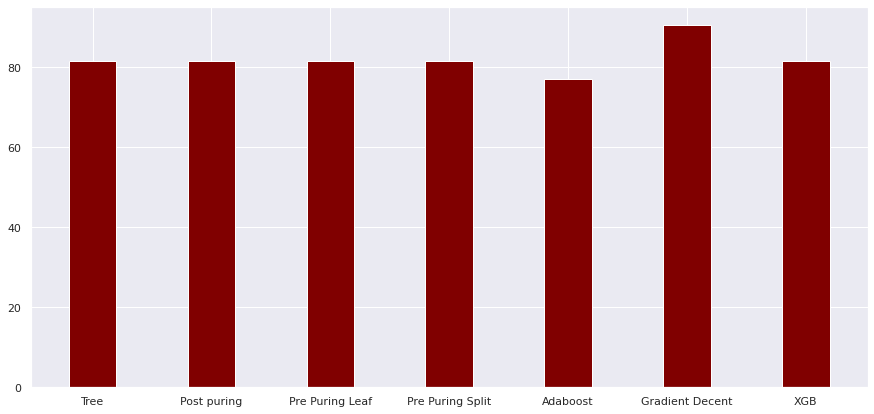

In [195]:
models = list(res.keys())
f1 = list(res.values())
fig = plt.figure(figsize =(15, 7))
display(res)
plt.bar(models, f1, color ='maroon',
        width = 0.4)

In [207]:
best_feature={}
for i in range(1,30):
  #best_feature={'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0,'10':0,
   #     '11':0,'12':0,'13':0,'14':0,'15':0,'16':0,'17':0,'18':0,'19':0,'20':0,
   #     '21':0,'22':0,'23':0,'24':0,'25':0,'26':0,'27':0,'28':0,'29':0}
  xy,xyz=sk(i)
  best_feature[str(i)]=round(grade(xy,xyz)*100,2)
  #print(i,grade(xy,xyz))

[('19', 91.53),
 ('9', 91.14),
 ('11', 90.3),
 ('17', 89.92),
 ('12', 89.83),
 ('23', 89.74),
 ('7', 89.45),
 ('15', 89.45),
 ('14', 89.36),
 ('21', 89.17),
 ('4', 88.98),
 ('25', 88.98),
 ('26', 88.51),
 ('27', 88.51),
 ('6', 88.41),
 ('24', 88.14),
 ('18', 87.93),
 ('13', 87.76),
 ('8', 87.72),
 ('22', 87.45),
 ('10', 86.81),
 ('20', 86.81),
 ('3', 86.58),
 ('28', 86.55),
 ('29', 86.55),
 ('16', 86.46),
 ('5', 85.84),
 ('2', 80.7),
 ('1', 74.61)]

<BarContainer object of 29 artists>

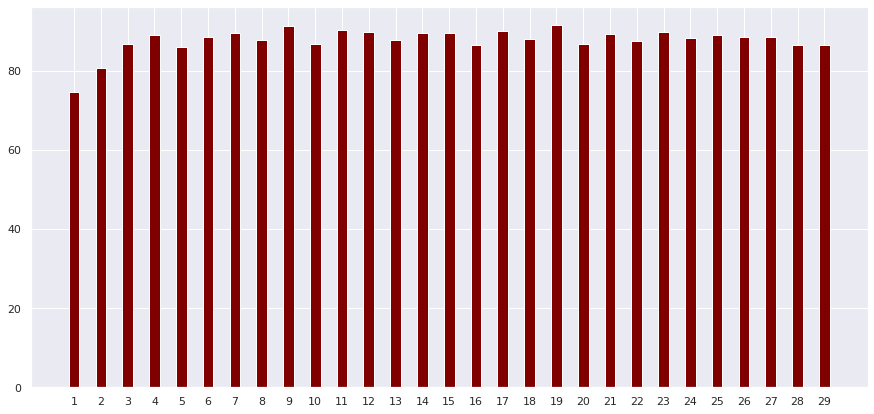

In [208]:
models = list(best_feature.keys())
f1 = list(best_feature.values())
fig = plt.figure(figsize =(15, 7))
display(sorted(best_feature.items(), key=lambda x:x[1],reverse = True))
plt.bar(models, f1, color ='maroon',
        width = 0.4)

In [140]:
x=test.drop(['Loan_ID'],axis=1)
x=trf1.transform(x)
x=trf2.transform(x)

In [141]:
xxy={}
for i in range(len(x.T)):
    xxy[str(i)]=list(x.T[i])
xxy=pd.DataFrame(xxy)

In [144]:
xy,xyz=sk(12)
xxy=xxy[xy.columns]

In [146]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.30)
gradient_booster.fit(xy,y_train)
pp=gradient_booster.predict(xxy)

In [147]:
pp

array(['Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y',
       'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N',
       'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y',
       'Y', 'N', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'N', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N',
       'N', 'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'N',
       'N', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y

In [148]:
test['Loan Status Predicted']=0
for i in test.index:
  test.loc[i,'Loan Status Predicted']=pp[i]

In [149]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan Status Predicted
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban,Y
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban,Y
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban,Y
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban,Y
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban,N


In [ ]:
#test.to_excel('C:\\Users\\adity\\OneDrive\\Documents\\Python Scripts\\Kaggle\\Loan\\Predicted Dataset.xlsx')

In [213]:
!apt-get update
!apt-get install inkscape
!add-apt-repository universe
!add-apt-repository ppa:inkscape.dev/stable
!apt-get update
!apt install inkscape

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net

In [214]:
!apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-fonts-recommended set to manually installed.
texlive-xetex is already the newest version (2017.20180305-1).
The following packages were automatically installed and are no longer required:
  fig2dev libdbus-glib-1-2 libgtkmm-2.4-1v5 libgtkspell0 libnvidia-common-460
  python-bs4 python-chardet python-html5lib python-lxml python-pkg-resources
  python-scour python-six python-webencodings scour transfig
Use 'apt autoremove' to remove them.
The following NEW packages will be installed:
  texlive-generic-recommended
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 15.9 kB of archives.
After this operation, 69.6 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 texlive-generic-recommended all 2017.20180305-1 [15.9 kB]
Fetched 15.9 kB in 

In [215]:
!jupyter nbconvert --to PDF 'Loan Predictor better accuracy.ipynb'

[NbConvertApp] WARNING | pattern 'Loan Predictor better accuracy.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=